In [6]:
import os 
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import skimage
import cv2
import networkx as nx
import random
from scipy.ndimage import label
import heapq

In [7]:
img_trial = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data\scans DICOM\NLD-AMPH-0059.dcm')
img_trial_pixel_data = sitk.GetArrayFromImage(img_trial)

In [8]:
seg_trial = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data\nnUNet_raw_data\Task502_CardiacOCT\labelsTr\NLDAMPH0059_014.nii.gz')
seg_trial_pixel_data = sitk.GetArrayFromImage(seg_trial)

In [9]:
frame_annots = []

for frame in range(seg_trial_pixel_data.shape[0]):
    if np.all((seg_trial_pixel_data[frame,:,:] == -1)):
        continue

    else:
        frame_annots.append(frame)

frame_annots

[0, 40, 80, 100, 120, 160, 200, 221, 251]

[[     0 360543]
 [     1  27469]
 [     2  31301]
 [     3  37355]
 [     4  12319]
 [     5  11031]
 [     6   9000]
 [     7   6598]]


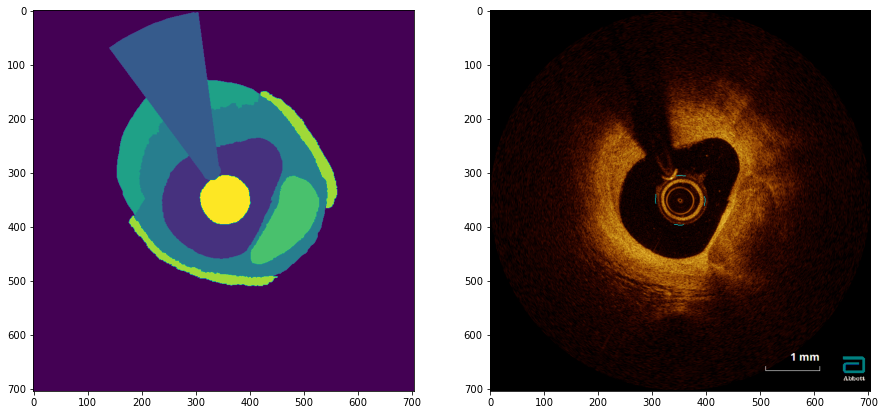

In [10]:
frame = 100

fig, axes = plt.subplots(1,2, figsize=(15,15))

axes[0].imshow(seg_trial_pixel_data[frame,:,:])
axes[1].imshow(img_trial_pixel_data[frame,:,:])

unique, counts = np.unique(seg_trial_pixel_data[frame,:,:], return_counts=True)
print(np.asarray((unique, counts)).T)

In [88]:
frame_sample = seg_trial_pixel_data[frame,:,:]
frame_image = img_trial_pixel_data[frame,:,:]

value_seg = np.sqrt(((frame_sample.shape[0]/2.0)**2.0)+((frame_sample.shape[1]/2.0)**2.0))
polar_seg = cv2.linearPolar(frame_sample,(frame_sample.shape[0]/2, frame_sample.shape[1]/2), value_seg, cv2.WARP_FILL_OUTLIERS)
polar_seg = polar_seg.astype(np.uint16)

value_img = np.sqrt(((frame_image.shape[0]/2.0)**2.0)+((frame_image.shape[1]/2.0)**2.0))
polar_img = cv2.linearPolar(frame_image,(frame_image.shape[0]/2, frame_image.shape[1]/2), value_img, cv2.WARP_FILL_OUTLIERS)
polar_img = polar_img.astype(np.uint32)

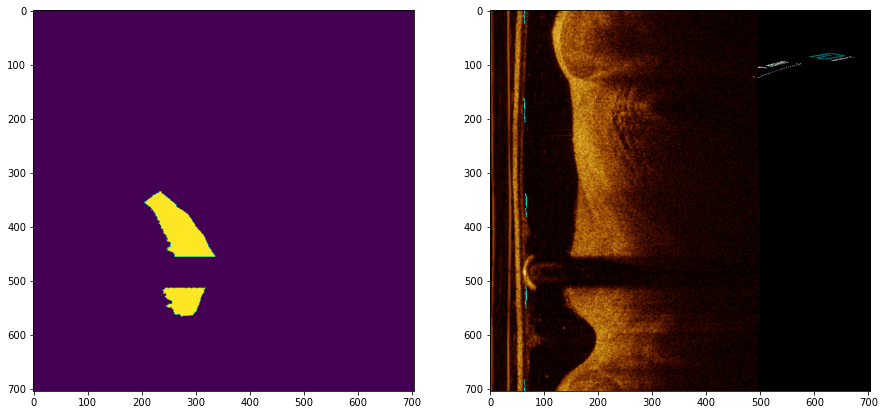

: 

In [89]:
fig, axes = plt.subplots(1,2, figsize=(15,15))

axes[0].imshow(polar_seg)
axes[1].imshow(polar_img)

## Dijkstra algorithm

In [15]:
#Take only lipid labels, rest are 0
for i in range(frame_sample.shape[0]):
    for j in range(frame_sample.shape[1]):

        if frame_sample[i, j] == 4:
            frame_sample[i, j] = 1

        else:
            frame_sample[i, j] = 0

In [16]:
#Find different clusters of lipid in segmentation. We'll find the shortest path for each one
segmentation, num_clusters = label(frame_sample)

[[     0 483297]
 [     1   3648]
 [     2   8671]]


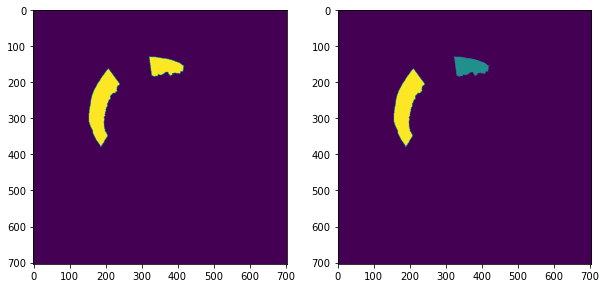

In [74]:
unique, counts = np.unique(segmentation, return_counts=True)
print(np.asarray((unique, counts)).T)

fig, axes = plt.subplots(1,2, figsize=(10,10))

axes[0].imshow(frame_sample)
axes[1].imshow(segmentation)

In [54]:
def dijkstra(graph, start, end):
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    priority_queue = [(0, start)]
    while priority_queue:
        (current_distance, current_node) = heapq.heappop(priority_queue)
        if current_node == end:
            break
        for neighbor, weight in graph[current_node].items():
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                heapq.heappush(priority_queue, (distance, neighbor))
    return distances[end]

In [75]:
def get_max_distance_points(segmentation):
    rows, cols = segmentation.shape
    graph = {}
    for row in range(rows):
        for col in range(cols):
            if segmentation[row, col] == 0:
                current_node = (row, col)
                neighbors = []
                if row > 0 and segmentation[row-1, col] == 1:
                    neighbors.append((row - 1, col))
                if row < rows - 1 and segmentation[row+1, col] == 1:
                    neighbors.append((row + 1, col))
                if col > 0 and segmentation[row, col-1] == 1:
                    neighbors.append((row, col - 1))
                if col < cols - 1 and segmentation[row, col+1] == 1:
                    neighbors.append((row, col + 1))
                graph[current_node] = {}
                for neighbor in neighbors:
                    graph[current_node][neighbor] = np.linalg.norm(np.array(current_node) - np.array(neighbor))
    max_distance = 0
    max_distance_points = (None, None)
    for node1 in graph.keys():
        for node2 in graph[node1].keys():
            distance = dijkstra(graph, node1, node2)
            if distance > max_distance:
                max_distance = distance
                max_distance_points = (node1, node2)
    return max_distance_points

In [76]:
get_max_distance_points(segmentation)

KeyError: (129, 322)

In [68]:
G = nx.Graph()

for row in range(frame_sample.shape[0]):
    for col in range(frame_sample.shape[1]):
        if frame_sample[row, col] == 1:
            G.add_node((row, col))

In [69]:
for node1 in G.nodes():
    for node2 in G.nodes():
        if node1 != node2:
            distance = ((node1[0] - node2[0]) ** 2 + (node1[1] - node2[1]) ** 2) ** 0.5
            if distance <= 1:
                G.add_edge(node1, node2, weight=distance)

In [71]:
nx.is_connected(G)

False

In [49]:
start_node = list(G.nodes())[0]
start_node

(129, 322)

In [50]:
start_node = random.choice(list(G.nodes()))
print(start_node)
shortest_paths = nx.single_source_dijkstra_path_length(G, start_node)

(308, 167)


In [51]:
longest_distance = -1
end_node = None
for node, distance in shortest_paths.items():
    if distance > longest_distance:
        longest_distance = distance
        end_node = node

In [52]:
shortest_path = nx.dijkstra_path(G, start_node, end_node)

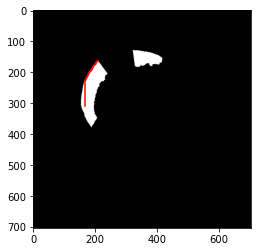

In [53]:
plt.imshow(frame_sample, cmap='gray')
plt.plot([node[1] for node in shortest_path], [node[0] for node in shortest_path], 'r-')
plt.show()

In [6]:
frame_sample = seg_trial_pixel_data[frame,:,:]

for i in range(frame_sample.shape[0]):
    for j in range(frame_sample.shape[1]):

        if frame_sample[i][j] == 4 or frame_sample[i][j] == 2:
            frame_sample[i][j] = 1

        elif frame_sample[i][j] == 1 or frame_sample[i][j] == 7 or frame_sample[i][j] == 3:
            frame_sample[i][j] = 2

        else:
            frame_sample[i][j] = 0

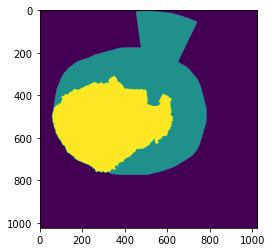

In [7]:
plt.imshow(frame_sample)

## Approach 1

In [71]:
#eroded_image = skimage.morphology.erosion(frame_sample)
dilated_image = skimage.morphology.dilation(frame_sample)

contours = skimage.measure.find_contours(dilated_image)

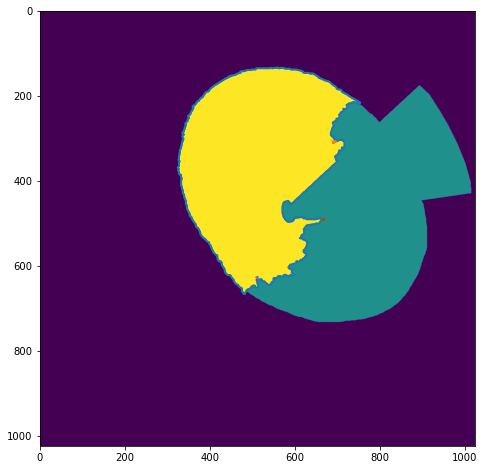

In [72]:
fig, ax = plt.subplots(1, figsize=(8,8))
ax.imshow(frame_sample)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

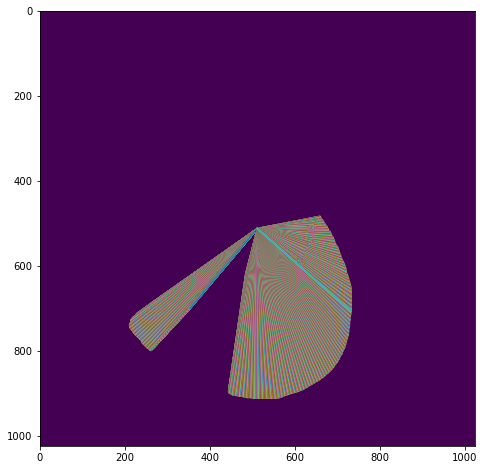

In [19]:
#Find distances
fig, ax = plt.subplots(1, figsize=(8,8))
ax.imshow(frame_sample.T)

for coord0 in contours[0]:
    x = np.linspace(coord0[0],512,100)
    y = np.linspace(coord0[1],512, 100)
    ax.plot(x, y)

for coord1 in contours[1]:
    x = np.linspace(coord1[0],512,100)
    y = np.linspace(coord1[1],512, 100)
    ax.plot(x, y)


In [67]:
extreme_points = []

for contour in contours:

    x, y = contour[:, 0], contour[:, 1]
    leftmost = tuple(contour[np.argmin(x)])
    rightmost = tuple(contour[np.argmax(x)])
    topmost = tuple(contour[np.argmin(y)])
    bottommost = tuple(contour[np.argmax(y)])

    extreme_points.append([leftmost, rightmost, topmost, bottommost])

[(666.5, 677.0), (884.5, 671.0), (725.0, 598.5), (673.0, 707.5)]
[(792.5, 478.0), (973.5, 464.0), (934.0, 297.5), (794.0, 481.5)]


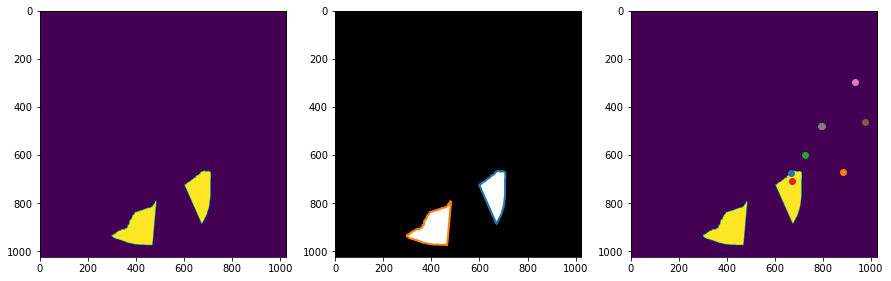

In [68]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(frame_sample)
ax[1].imshow(dilated_image, cmap=plt.cm.gray)

for contour in contours:
    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)

ax[2].imshow(dilated_image)

for cluster in extreme_points:
    print(cluster)
    for point in cluster:
        ax[2].scatter(point[0], point[1])

## Approach 2

In [38]:
# Find edges using Sobel operator
edges = skimage.filters.sobel(eroded_image)

# Find the coordinates of the non-zero pixels
coords = np.column_stack(np.nonzero(edges))

# Find the last pixel on the left side
top_side_pixels = coords[coords[:,0]==np.min(coords[:,0])]
last_top_pixel = top_side_pixels[np.argmax(top_side_pixels[:,1])]

# Find the last pixel on the right side
bottom_side_pixels = coords[coords[:,0]==np.max(coords[:,0])]
last_bottom_pixel = bottom_side_pixels[np.argmax(bottom_side_pixels[:,0])]

# Print the coordinates of the last pixels
print("Last pixel on the left side:", last_top_pixel)
print("Last pixel on the left side:", last_bottom_pixel)

Last pixel on the left side: [187 545]
Last pixel on the left side: [815 487]


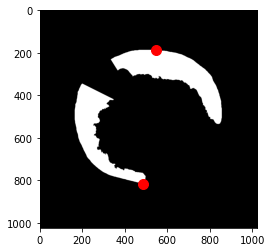

In [39]:
fig, ax = plt.subplots()
ax.imshow(frame_sample, cmap='gray')
ax.scatter(last_top_pixel[1], last_top_pixel[0], color='r', s=100)
ax.scatter(last_bottom_pixel[1], last_bottom_pixel[0], color='r', s=100)
plt.show()

In [40]:
m1 = ((512 - last_top_pixel[0]) / (512 - last_top_pixel[1]))
m2 = ((512 - last_bottom_pixel[0]) / (512 - last_bottom_pixel[1]))

b1 = last_top_pixel[0] - m1*last_top_pixel[1]
b2 = last_bottom_pixel[0] - m2*last_bottom_pixel[1]

angle = np.degrees(abs(np.arctan(m1) - np.arctan(m2)))

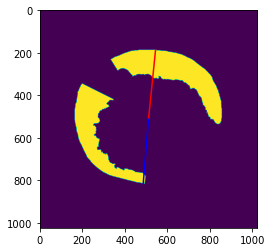

In [41]:
x_values1 = np.linspace(min(last_top_pixel[1], 512), max(last_top_pixel[1], 512), 100)
y_values1 = m1 * x_values1 + b1

x_values2 = np.linspace(min(last_bottom_pixel[1], 512), max(last_bottom_pixel[1], 512), 100)
y_values2 = m2 * x_values2 + b2

fig, ax = plt.subplots()

ax.imshow(frame_sample)
ax.plot(x_values1, y_values1, '-r', label='First line')
ax.plot(x_values2, y_values2, '-b', label='Second line')
plt.show()

In [ ]:
## TO DO: Filter to remove sparse labels (just obtain one cluster with the lipid pool)